### Cantilever FRP-Confined Circular Reinforced Concrete Column under Cyclic Lateral Loading

In [2]:
from openseespy.opensees import *
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv
%matplotlib widget

In [3]:
wipe()
model('basic', '-ndm', 2, '-ndf', 3)
# UNITS: N, mm, MPa

In [4]:
# make nodes

node(1, *[ 0.0, 0.0]) # support
node(2, *[ 0.0, 0.0]) # top of rotational spring
node(3, *[ 0.0, 200.0]) # top of column
node(4, *[ 0.0, 1350.0]) # mass concentration point

<Axes: >

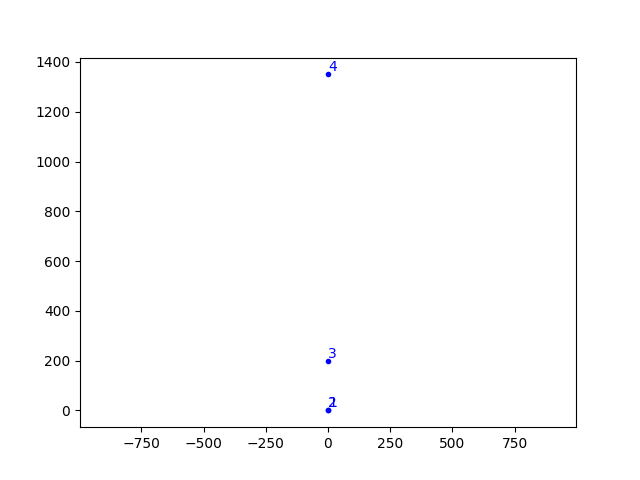

In [5]:
opsv.plot_model()

In [6]:
# Define materials

# 1. FRP-CONFINED CONCRETE

# uniaxialMaterial('FRPConfinedConcrete', matTag, fpc1, fpc2, epsc0, D, c, Ej, Sj, tj, eju, S, fyl, fyh, dlong, dtrans, Es, nu0, k, useBuck)
# uniaxialMaterial("FRPConfinedConcrete", 1, 27.5, 27.5, 0.002, 400.,35.,266000.,0.0,0.222,0.0163,150.,374.,363.,16.,6.,200000.,0.2,0.8,1.)
# *Above material not compiled by python due to faulty model*

# uniaxialMaterial('FRPConfinedConcrete02', matTag, fc0, Ec, ec0, <'-JacketC', tfrp, Efrp, erup, R>, <'-Ultimate', fcu, ecu>, ft, Ets, Unit)
uniaxialMaterial('FRPConfinedConcrete02', 1, -27.5, 24804., 0.002, '-JacketC', 0.222, 266000., 0.0163, 200., 3.314, 1240.2, 1)

# 2. ROTATIONAL SPRING
# uniaxialMaterial('Elastic', matTag, E)
uniaxialMaterial("Elastic",2,30849000000.) 

# 3. STEEL

# uniaxialMaterial('Steel02', matTag, Fy, E0, b, *params, a1=a2*Fy/E0, a2=1.0, a3=a4*Fy/E0, a4=1.0, sigInit=0.0)
uniaxialMaterial("Steel02",3,374.,200000.,0.,1.,0.01,0.01)

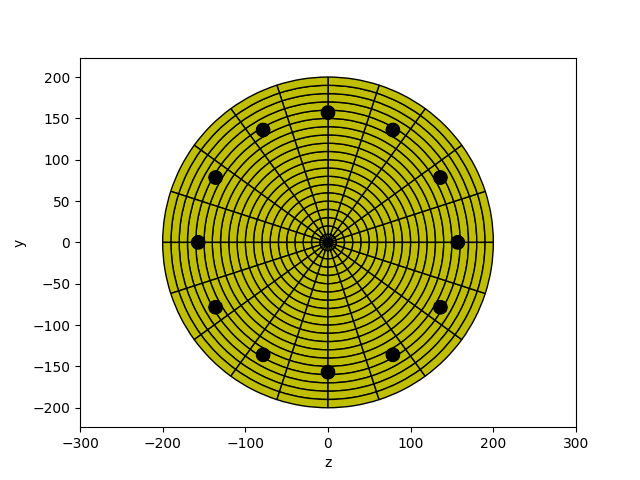

In [7]:
# Make fiber section

# patch('circ', matTag, numSubdivCirc, numSubdivRad, *center, *rad, *ang)
bar_loc = [[0., 157.0], [78.5, 135.966], [135.966, 78.5], [157., 0.], [135.966, -78.5], [78.5, -135.966], [0., -157.], [-78.5, -135.966], [-135.966, -78.5], [-157.0, 0.0], [-135.966, 78.5], [-78.5, 135.966]]
fib_sec_1 = [['section', 'fiber', 1, '-GJ', 1e-10],
             ['patch', 'circ', 1, 20, 20, *[0., 0.], *[0,200], *[0, 360]], # concrete
             ['patch', 'circ', 3, 10, 10, *bar_loc[0], *[0, 8], *[0, 360]], # bar1
             ['patch', 'circ', 3, 10, 10, *bar_loc[1], *[0, 8], *[0, 360]], # bar2
             ['patch', 'circ', 3, 10, 10, *bar_loc[2], *[0, 8], *[0, 360]], # bar3
             ['patch', 'circ', 3, 10, 10, *bar_loc[3], *[0, 8], *[0, 360]], # bar4
             ['patch', 'circ', 3, 10, 10, *bar_loc[4], *[0, 8], *[0, 360]], # bar5
             ['patch', 'circ', 3, 10, 10, *bar_loc[5], *[0, 8], *[0, 360]], # bar6
             ['patch', 'circ', 3, 10, 10, *bar_loc[6], *[0, 8], *[0, 360]], # bar7
             ['patch', 'circ', 3, 10, 10, *bar_loc[7], *[0, 8], *[0, 360]], # bar8
             ['patch', 'circ', 3, 10, 10, *bar_loc[8], *[0, 8], *[0, 360]], # bar9
             ['patch', 'circ', 3, 10, 10, *bar_loc[9], *[0, 8], *[0, 360]], # bar10
             ['patch', 'circ', 3, 10, 10, *bar_loc[10], *[0, 8], *[0, 360]], # bar11
             ['patch', 'circ', 3, 10, 10, *bar_loc[11], *[0, 8], *[0, 360]], # bar12
             ] 

opsv.fib_sec_list_to_cmds(fib_sec_1)
opsv.plot_fiber_section(fib_sec_1)
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.show()

In [8]:
# Make elements
geomTransf('Linear', 1)

# Rotational spring as Zero Length Element
# element('zeroLength', eleTag, *eleNodes, '-mat', *matTags, '-dir', *dirs, <'-doRayleigh', rFlag=0>, <'-orient', *vecx, *vecyp>)
element("zeroLength", 1, *[1, 2], '-mat', 2, '-dir', 3)


# COLUMN

# FRP-confined column as DisplacementBeamColumn element

# beamIntegration("Legendre", intTag, secTag, Npoints)
beamIntegration('Legendre', 1, 1, 4)

# element('dispBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-cMass', '-mass', mass=0.0)
element('dispBeamColumn', 2, *[2,3], 1, 1)

# Unconfined column as ElasticBeamColumn element

# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, <'-mass', mass>, <'-cMass'>, <'-release', releaseCode>)
element("elasticBeamColumn", 3, *[3, 4], 125663.706, 31540., 1290800000., 1) 

In [9]:
# Apply Boundary Condition
fix(1, *[1,1,1]) # [Ux, Uy, Rz]
equalDOF(1, 2, *[1, 2])

In [10]:
# Apply Load
timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(4, *[0.0, -185000.0, 0.0])

In [11]:
# Analyze vertical load
integrator("LoadControl", 0.1)
system("SparseGeneral", "-piv")  # Overkill but may need pivoting
test("NormUnbalance", 1.0e-6, 1000, 4)
numberer("Plain")
constraints("Plain")
algorithm("Newton")
analysis("Static")
analyze(10)
loadConst("-time", 0.0)

CTestNormUnbalance::test() - iteration: 1 current Norm: 16026.7 (max: 1e-06)
	Norm deltaX: 0.00647781, Norm deltaR: 16026.7
	deltaX: 3.53425e-37 -1.72265e-20 -0.00102792 1.72265e-22 -2.15331e-19 -0.00639574 1.72265e-22 
	deltaR: 5.85487e-11 6.89659e-29 -16026.7 -5.85487e-11 -4.34237e-30 3.63798e-12 3.32915e-27 
CTestNormUnbalance::test() - iteration: 2 current Norm: 13893.4 (max: 1e-06)
	Norm deltaX: 0.00126027, Norm deltaR: 13893.4
	deltaX: 9.02842e-36 8.12044e-20 -0.000891147 -8.12044e-22 1.01506e-18 -0.000891147 -8.12044e-22 
	deltaR: -2.22144e-10 -2.58494e-28 -13893.4 2.22144e-10 0 -3.63798e-12 1.33166e-26 
CTestNormUnbalance::test() - iteration: 3 current Norm: 12051.1 (max: 1e-06)
	Norm deltaX: 0.00109321, Norm deltaR: 12051.1
	deltaX: -1.07881e-35 -1.06205e-19 -0.000773017 1.06205e-21 -1.32756e-18 -0.000773017 1.06205e-21 
	deltaR: -2.24759e-10 -7.15713e-28 -12051.1 2.24759e-10 6.94779e-29 0 3.32915e-26 
CTestNormUnbalance::test() - iteration: 4 current Norm: 10458.4 (max: 1e-06

Text(0.5, 1.0, 'Axial Deformation of column under vertical load')

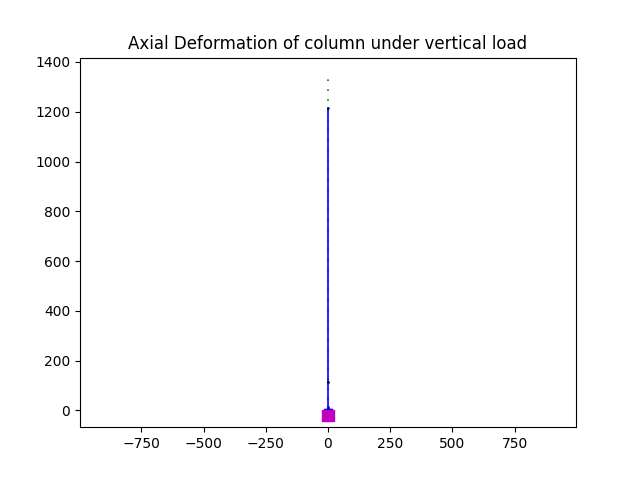

In [12]:
opsv.plot_defo()
plt.title('Axial Deformation of column under vertical load')

In [13]:
# Record displacement
recorder('Node', '-file', "Displ_Node_4", '-closeOnWrite', '-node', 4, '-dof', 1, 'disp')
recorder('Node', '-file', "React_Node_2", '-closeOnWrite', '-node', 2, '-dof', 1, 'reaction')

1

In [14]:
# Apply lateral load
timeSeries('Linear', 2)
pattern('Plain', 2, 2)
load(4, *[1., 0., 0.])

In [15]:
# Pushover analysis - Apply lateral displacement at node 4
wipeAnalysis()
system("SparseGeneral","-piv")    # Overkill, but may need the pivoting!
test("NormUnbalance", 1.0e-6, 50000)
numberer("Plain")
constraints("Plain")
algorithm("ModifiedNewton", "-initial")

In [16]:
# pushData = np.zeros((len(disp_step)+1, 2))
disp = [0]
force = [0]

maxDisp = 20.
dispIncr = 0.1

current_disp = 0.0
ok = 0.0

while ok == 0 and current_disp < maxDisp:
    integrator('DisplacementControl', 4, 1, dispIncr)
    analysis("Static")
    ok = analyze(1)
    
    # pushData[i+1, 0] = nodeDisp(4,1)
    current_disp = nodeDisp(4,1)
    disp.append(current_disp)
    
    reactions()
    # pushData[i+1, 1] = -nodeReaction(4,1)
    current_rxn = -nodeReaction(2,1)
    force.append(current_rxn)

    if ok != 0:
        print(f"Analysis failed at step {current_disp+dispIncr}.")
    else:
        print("Analysis completed successfully.")

Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis completed successfully.
Analysis c

after: 50000 iterations  current Norm: 1.18624e-06 (max: 1e-06, Norm deltaX: 6.27577e-17)
ModifiedNewton::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 41245.2
OpenSees > analyze failed, returned: -3 error flag


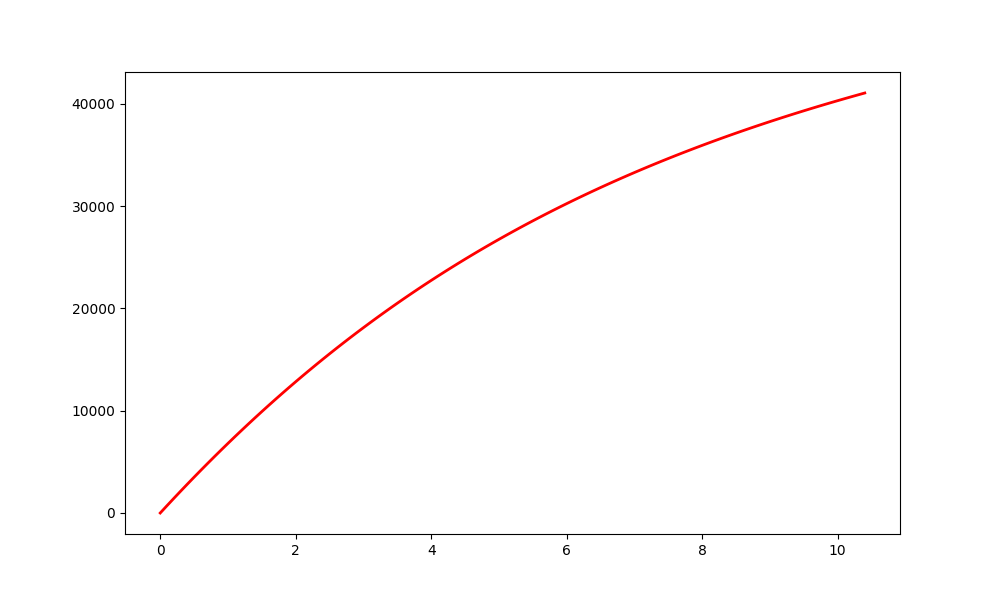

In [17]:
plt.figure(figsize=(10,6))
# plt.plot(pushData[:, 0], pushData[:, 1])
plt.plot(disp, force, color='r', linewidth=2)
plt.show()

12.980769230769257

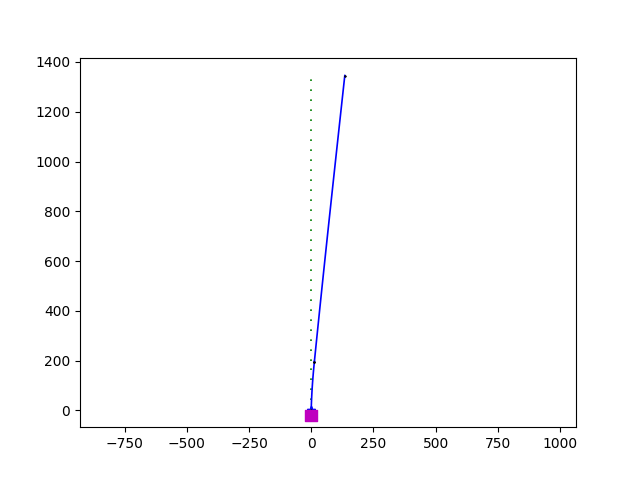

In [18]:
opsv.plot_defo()

In [20]:
len(disp)

106